In [1]:
from random import uniform
from time import time

from math import ceil
from math import sqrt

from multiprocessing import Pool 
from multiprocessing import cpu_count

import dask.array as da
import numpy as np

my_number_processes = cpu_count()

###
# Define all functions to be used
###

def perform_MC(number_of_darts):
    """
    Performs a Monte Carlo simulation to the area of a circle
    From this calculatePi() will estimate the value of pi
    
    Input:
    number_of_darts: Number of darts to throw
    
    Output:
    number_of_darts: Number of darts thrown, the input
    number_of_darts_in_circle: Number of darts which landed in the circle
    """

    #Number of darts that fall inside circle
    number_of_darts_in_circle = 0
    
    #Perform Monte Carlo
    #Circle is centered at (.5,.5) with radius .5
    
    #This was the code given in the example - much slower than numpy!
    for _ in range(number_of_darts):
        x,y = uniform(0,1),uniform(0,1)
        if sqrt((x-.5)**2 + (y-.5)**2) <= .5:
            number_of_darts_in_circle += 1

    #To fairly compare serial & multiprocessing with dask we should use numpy code for serial & multiprocessing
#     xy = np.random.uniform(0,1,size=(number_of_darts,2))
#     number_of_darts_in_circle = np.sum(np.sqrt((xy[:,0]-.5)**2 + (xy[:,1]-.5)**2)  <= .5)

    return number_of_darts, number_of_darts_in_circle

def calculate_Pi(number_of_darts,number_of_darts_in_circle):
    """
    Approximate pi using number_of_darts_in_circle / float(number_of_darts) = (Area circle)/(Area square) = pi*r**2/(2*r)**2 
    """
    return 2**2 * number_of_darts_in_circle/float(number_of_darts)

def pi_MC_serial(nd):
    """
    Performs Monte Carlo with no parallelism
    As this assignment is designed to explore parallelism, we record the execution time of the simulation
    
    Input:
    nd: Number of darts to throw
    
    Output:
    pi_approx: Approximation of pi
    nd: Number of darts thrown, the input
    execution_time: Execution time of Monte Carlo simulation
    darts_per_second: Number of darts thrown per second 
    """
    
    #Begin timing
    start_time = time()
    
    #Perform Monte Carlo and estimate pi
    nd_notused, nc = perform_MC(nd)
    pi_approx = calculate_Pi(nd,nc)
    
    #Get end time, and from that calculate execution time
    end_time = time()
    execution_time = end_time - start_time
    
    #Calculate number of darts thrown per second
    darts_per_second = nd/execution_time

    return pi_approx, nd, execution_time, darts_per_second

def pi_MC_multiprocessing(nd,number_processes = my_number_processes):
    """
    Performs Monte Carlo with multiprocessing using all available CPUs
    As this assignment is designed to explore parallelism, we record the execution time of the simulation
    
    Input:
    nd: Number of darts to throw
    
    Output:
    pi_approx: Approximation of pi
    nd: Number of darts thrown, the input
    execution_time: Execution time of Monte Carlo simulation
    darts_per_second: Number of darts thrown per second 
    """
    #Start timing
    start_time = time()

    nd_one_process = int(np.round(nd/number_processes))
    nd_list = [nd_one_process] * number_processes
    nd_list[-1] += nd - sum(nd_list)

    pool = Pool(processes=number_processes) #start up the pool
    results = pool.map(perform_MC, nd_list)
    pool.close() # shut down the pool

    nd = sum([res[0] for res in results]) #Sum up to get total number of darts thrown
    nc = sum([res[1] for res in results]) #Sum up to get total number of darts in circle

    pi_approx = calculate_Pi(nd,nc)

    #End timing
    end_time = time()
    execution_time = end_time - start_time
    
    #Calculate number of darts thrown per second
    darts_per_second = nd/execution_time

    return pi_approx, nd, execution_time, darts_per_second

def pi_MC_dask(nd,number_processes = my_number_processes):
    """
    Performs Monte Carlo with Dask
    As this assignment is designed to explore parallelism, we record the execution time of the simulation
    Does NOT use perform_MC as pi_MC_serial and pi_MC_multiprocessing do
    
    Input:
    nd: Number of darts to throw
    
    Output:
    pi_approx: Approximation of pi
    nd: Number of darts thrown, the input
    execution_time: Execution time of Monte Carlo simulation
    darts_per_second: Number of darts thrown per second 
    """
    #Start timing
    start_time = time()

    nd_one_process = int(np.ceil(nd/number_processes))
    nd_list = [nd_one_process] * number_processes
    nd_list[-1] += nd - sum(nd_list)

    #Number of darts that fall inside circle

    xy = da.random.uniform(0,1,size=(nd,2),chunks=(nd_one_process,2))
    number_of_darts_in_circle = da.sum(da.sqrt(da.square(xy[:,0]-.5) + da.square(xy[:,1]-.5))  <= .5)
    nc = number_of_darts_in_circle.compute()

    pi_approx = calculate_Pi(nd,nc)

    #End timing
    end_time = time()
    execution_time = end_time - start_time

    #Calculate number of darts thrown per second
    darts_per_second = nd/execution_time

    return pi_approx, nd, execution_time, darts_per_second

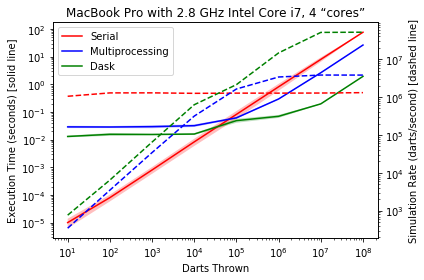

In [5]:
import matplotlib.pyplot as plt
import pickle 

#Use pickle to load simulations data
filehandler = open('data.p', 'rb') 
pi_s, nd_s, ex_s, dps_s,pi_mp, nd_mp, ex_mp, dps_mp,pi_d, nd_d, ex_d, dps_d = pickle.load(filehandler)
filehandler.close()

fig, ax1 = plt.subplots()

ax1.set_title('MacBook Pro with 2.8 GHz Intel Core i7, 4 “cores”')

#Plot execution times
ax1.loglog(nd_s, ex_s.mean(axis=0), 'r',label = "Serial")
ax1.loglog(nd_mp, ex_mp.mean(axis=0), 'b',label = "Multiprocessing")
ax1.loglog(nd_d, ex_d.mean(axis=0), 'g',label = "Dask")
ax1.set_xlabel("Darts Thrown")
ax1.set_ylabel("Execution Time (seconds) [solid line]")

#If we had > 1 sample, create error bars
x,y1,y2 = nd_s,ex_s.mean(axis=0) - ex_s.std(axis=0),ex_s.mean(axis=0) + ex_s.std(axis=0)
ax1.fill_between(x,y1,y2,where= (y2 >= y1) & (y1 > 0),facecolor='red', alpha=0.25)
x,y1,y2 = nd_mp,ex_mp.mean(axis=0) - ex_mp.std(axis=0),ex_mp.mean(axis=0) + ex_mp.std(axis=0)
ax1.fill_between(x,y1,y2,where= (y2 >= y1) & (y1 > 0),facecolor='blue', alpha=0.25)
x,y1,y2 = nd_d,ex_d.mean(axis=0) - ex_d.std(axis=0),ex_d.mean(axis=0) + ex_d.std(axis=0)
ax1.fill_between(x,y1,y2,where= (y2 >= y1) & (y1 > 0),facecolor='green', alpha=0.25)

#Plot darts thrown per second
ax2 = ax1.twinx()
ax2.loglog(nd_s, dps_s.mean(axis=0), 'r--')
ax2.loglog(nd_mp, dps_mp.mean(axis=0), 'b--')
ax2.loglog(nd_d, dps_d.mean(axis=0), 'g--')
ax2.set_ylabel("Simulation Rate (darts/second) [dashed line]")

ax1.legend()

fig.tight_layout()
#plt.savefig('simulation_results.png') #Save to file
plt.show()

In [5]:
###
# Compare execution times for a single round of darts
###

number_of_darts = round(10**7)

print(pi_MC_serial(number_of_darts))
print(pi_MC_multiprocessing(number_of_darts))
print(pi_MC_dask(number_of_darts))

(3.1408516, 10000000, 18.40689206123352, 543274.7672303056)
(3.140418, 10000000, 5.345279932022095, 1870809.4107649561)
(3.1414900000000001, 10000000, 0.43804001808166504, 22828964.448941447)


In [6]:
###
# Code generating data for plots
###

import pickle 

number_samples = 20

nd = np.repeat([np.logspace(1,8,8,dtype=int)],number_samples,axis = 0)
#nd = np.logspace(1,5,10,dtype=int)

#Get results for serial
pi_s, nd_s, ex_s, dps_s = np.vectorize(pi_MC_serial)(nd)
#For multiprocessing
pi_mp, nd_mp, ex_mp, dps_mp = np.vectorize(pi_MC_multiprocessing)(nd)
#For dask
pi_d, nd_d, ex_d, dps_d = np.vectorize(pi_MC_dask)(nd)

nd_s = nd_s.mean(axis=0) #same for every row - turn back into a vector
nd_mp = nd_mp.mean(axis=0)
nd_d = nd_d.mean(axis=0)

filehandler = open('data.p', 'wb') 
pickle.dump([pi_s, nd_s, ex_s, dps_s,pi_mp, nd_mp, ex_mp, dps_mp,pi_d, nd_d, ex_d, dps_d], filehandler)
filehandler.close()
